# Number of nodes per km2 in each hexres9

## Importing libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import esda
import pysal
import libpysal as lps
from splot import esda as esdaplot


module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-02-20 20:15:26 Configured OSMnx 1.1.1
2023-02-20 20:15:26 HTTP response caching is on


## Downloading data

hexres9 from 2km buffer

<AxesSubplot:>

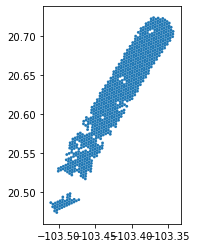

In [2]:
hex_2km = aup.gdf_from_db('censo1020_mza_hexres9_buffer2km','segundopiso')
hex_2km.plot()

Nodes

<AxesSubplot:>

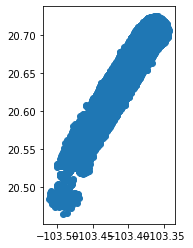

In [4]:
nodes_2km = aup.gdf_from_db('nodes_dist_lopezmateos','segundopiso')
nodes_2km.plot()

## Spatial join

hex info to nodes

In [7]:
nodes_hex9 = nodes_2km.overlay(hex_2km)
print(nodes_hex9.shape)
nodes_hex9.head(2)

(23726, 443)


,x,y,street_count,dist_lpz_mateos,hex_id_9,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,...,Chng_RVivHab_10,DensPob_10_20,city,ubicacion,viv_serv,10_viv_serv,%vivconauto,10_%vivconauto,chg_%vivconauto_10_20,geometry
0,-103.386953,20.674556,3,0.155880,89498c96d4bffff,199.0,103.0,91.0,4.0,3.0,...,0.772727,0.646719,Guadalajara,Norte del periferico,85.0,61.0,87.058824,83.606557,3.452266,POINT (-103.38695 20.67456)
1,-103.387021,20.674199,3,0.700245,89498c96d4bffff,199.0,103.0,91.0,4.0,3.0,...,0.772727,0.646719,Guadalajara,Norte del periferico,85.0,61.0,87.058824,83.606557,3.452266,POINT (-103.38702 20.67420)


Grouping by hex and counting

In [15]:
nodes_hex9_sum = nodes_hex9.groupby('hex_id_9').count()
nodes_hex9_sum = nodes_hex9_sum.reset_index().rename(columns={'x':'node_count'})
nodes_hex9_sum = nodes_hex9_sum[['hex_id_9','node_count']].copy()

print(nodes_hex9_sum.shape)
nodes_hex9_sum.head(2)

(850, 2)


,hex_id_9,node_count
0,89498c941a7ffff,9
1,89498c941b7ffff,7


Joining with geometry layer

In [22]:
hexres9_nodecount = hex_2km.merge(nodes_hex9_sum, on='hex_id_9', how='left')
print(hexres9_nodecount.shape)
hexres9_nodecount.head(1)

(853, 440)


,hex_id_9,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,...,DensPob_10_20,city,ubicacion,geometry,viv_serv,10_viv_serv,%vivconauto,10_%vivconauto,chg_%vivconauto_10_20,node_count
0,89498c96ddbffff,579.0,313.0,266.0,3.0,0.0,0.0,571.0,309.0,262.0,...,-2.263532,Guadalajara,Norte del periferico,"POLYGON ((-103.39147 20.66055, -103.39026 20.6...",188.0,184.0,87.765957,89.130435,-1.364477,25.0


In [29]:
fields_tokeep = ['hex_id_9','geometry','ubicacion','node_count']
hexres9_ncount = hexres9_nodecount[fields_tokeep]
hexres9_ncount.head(1)

,hex_id_9,geometry,ubicacion,node_count
0,89498c96ddbffff,"POLYGON ((-103.39147 20.66055, -103.39026 20.6...",Norte del periferico,25.0


## Calculating nodes/km2

In [37]:
hex_temp = hexres9_ncount.copy()
hex_temp = hex_temp.to_crs("EPSG:6372")
hex_temp['area_has'] = hex_temp.area/10000
hex_temp = hex_temp.to_crs("EPSG:4326")
hex_temp.head(1)

,hex_id_9,geometry,ubicacion,node_count,area_has
0,89498c96ddbffff,"POLYGON ((-103.39147 20.66055, -103.39026 20.6...",Norte del periferico,25.0,12.370048


In [38]:
hex_temp['node_density'] = hex_temp['node_count'] / hex_temp['area_has']
hex_temp.head(1)

,hex_id_9,geometry,ubicacion,node_count,area_has,node_density
0,89498c96ddbffff,"POLYGON ((-103.39147 20.66055, -103.39026 20.6...",Norte del periferico,25.0,12.370048,2.021011


## Saving to db

In [39]:
aup.gdf_to_db_slow(hex_temp,'nodedensity_2km_hexres9','segundopiso',if_exists="replace")